In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
train_dir = "../train" #passing the path with training images
test_dir = "../test"   #passing the path with testing images

In [3]:
img_size = 48

In [4]:
train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)



train_datagen = ImageDataGenerator(width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [5]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                                                         )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [6]:
X_train, y_train = next(train_generator)
X_test, y_test = next(validation_generator)

In [7]:
len(train_generator)

359

In [8]:
X_train.shape

(64, 48, 48, 1)

In [9]:
y_train.shape

(64, 7)

In [10]:
X_test.shape

(64, 48, 48, 1)

In [11]:
y_test.shape

(64, 7)

In [12]:
class_names = train_generator.class_indices

class_names_swap = {v: k for k, v in class_names.items()}
print(class_names_swap)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


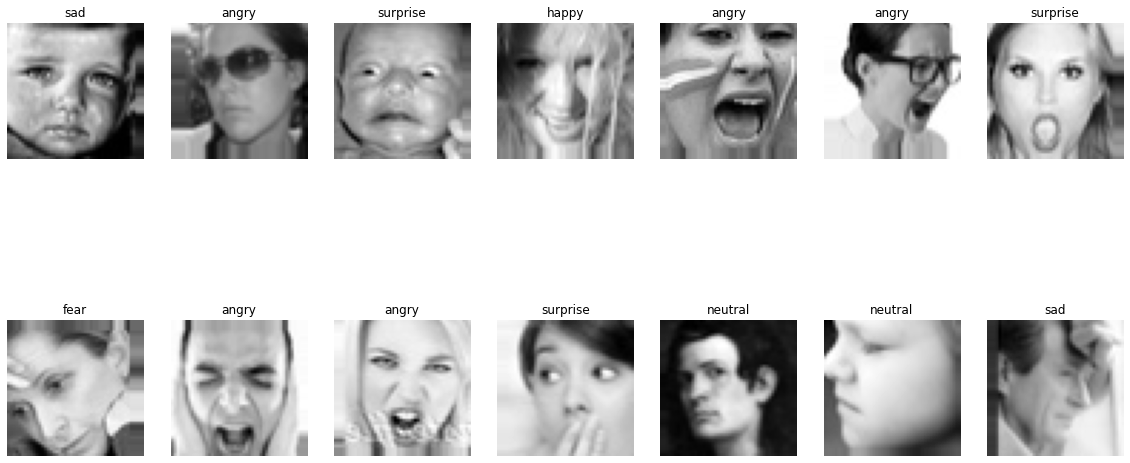

In [13]:
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np 

r = random.sample(range(X_train.shape[0]), 14)
for i in range(14):
    plt.subplot(2, 7, i+1)
    plt.imshow(X_train[r[i]],'gray')
    plt.title(class_names_swap[np.argmax(y_train[r[i]])])
    plt.axis("off")    

In [14]:
from sklearn.utils import class_weight 
import numpy as np

class_weights = class_weight.compute_class_weight(
            class_weight = 'balanced',
            classes = np.unique(train_generator.classes), 
            y = train_generator.classes)

train_class_weights = dict(enumerate(class_weights))
# model.fit_generator(..., class_weight=train_class_weights)

In [15]:
train_class_weights

{0: 1.0266404434114071,
 1: 9.401555464592715,
 2: 1.0009587727708533,
 3: 0.5684585684585685,
 4: 0.826068191627104,
 5: 0.8491570541259982,
 6: 1.2933160650937552}

In [16]:
class_names_swap

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [17]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation(tf.keras.layers.LeakyReLU(alpha=0.01))(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation(tf.keras.layers.LeakyReLU(alpha=0.01))(x)
    return x

In [18]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation(tf.keras.layers.LeakyReLU(alpha=0.01))(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation(tf.keras.layers.LeakyReLU(alpha=0.01))(x)
    return x

In [19]:
def model_five(shape = (32, 32, 3), classes = 10):
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.keras.layers.LeakyReLU(alpha=0.01))(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = convolutional_block(x, 128)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = convolutional_block(x, 256)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = convolutional_block(x, 512)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 512)
    
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = tf.keras.layers.LeakyReLU(alpha=0.01))(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "model_two")
    return model

In [20]:
model = model_five(shape = (48, 48, 1), classes = 7)

epochs = 200
batch_size = 64
model.summary()

Model: "model_two"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 54, 54, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 27, 27, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 27, 27, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                               

                                                                                                  
 activation_8 (Activation)      (None, 7, 7, 128)    0           ['add_3[0][0]']                  
                                                                                                  
 dropout (Dropout)              (None, 7, 7, 128)    0           ['activation_8[0][0]']           
                                                                                                  
 conv2d_10 (Conv2D)             (None, 7, 7, 128)    147584      ['dropout[0][0]']                
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 7, 7, 128)   512         ['conv2d_10[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activatio

                                                                                                  
 batch_normalization_18 (BatchN  (None, 7, 7, 128)   512         ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_8 (Add)                    (None, 7, 7, 128)    0           ['batch_normalization_18[0][0]', 
                                                                  'activation_16[0][0]']          
                                                                                                  
 activation_18 (Activation)     (None, 7, 7, 128)    0           ['add_8[0][0]']                  
                                                                                                  
 conv2d_20 (Conv2D)             (None, 4, 4, 256)    295168      ['activation_18[0][0]']          
          

 conv2d_29 (Conv2D)             (None, 4, 4, 256)    590080      ['dropout_3[0][0]']              
                                                                                                  
 batch_normalization_27 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_29[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_27 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_27[0][0]'] 
                                                                                                  
 conv2d_30 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_27[0][0]']          
                                                                                                  
 batch_normalization_28 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_30[0][0]']              
 ormalizat

                                                                  'activation_34[0][0]']          
                                                                                                  
 activation_36 (Activation)     (None, 4, 4, 256)    0           ['add_17[0][0]']                 
                                                                                                  
 conv2d_39 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_36[0][0]']          
                                                                                                  
 batch_normalization_37 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_39[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_37 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_37[0][0]'] 
          

 activation_45 (Activation)     (None, 2, 2, 512)    0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_49 (Conv2D)             (None, 2, 2, 512)    2359808     ['activation_45[0][0]']          
                                                                                                  
 batch_normalization_46 (BatchN  (None, 2, 2, 512)   2048        ['conv2d_49[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_22 (Add)                   (None, 2, 2, 512)    0           ['batch_normalization_46[0][0]', 
                                                                  'dropout_6[0][0]']              
                                                                                                  
 activatio

                                                                                                  
 batch_normalization_55 (BatchN  (None, 2, 2, 512)   2048        ['conv2d_58[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 2, 2, 512)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_59 (Conv2D)             (None, 2, 2, 512)    2359808     ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_56 (BatchN  (None, 2, 2, 512)   2048        ['conv2d_59[0][0]']              
 ormalization)                                                                                    
          

In [21]:
learning_rate = 0.001
decay_rate = learning_rate / 25
# momentum = 0.8
opt = Adam(lr=learning_rate,  decay=decay_rate)


model.compile(
    optimizer = opt, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    'fer-43.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [23]:
import scipy.integrate

import scipy.special
import scipy

history = model.fit(x = train_generator,epochs = epochs,batch_size=batch_size,validation_data = validation_generator, class_weight=train_class_weights)

Epoch 1/200
359/359 [==============================] - 425s 1s/step - loss: 2.3240 - accuracy: 0.1584 - val_loss: 1.9181 - val_accuracy: 0.1334
Epoch 2/200
359/359 [==============================] - 111s 308ms/step - loss: 1.9052 - accuracy: 0.1833 - val_loss: 1.8575 - val_accuracy: 0.2521
Epoch 3/200
359/359 [==============================] - 114s 316ms/step - loss: 1.8359 - accuracy: 0.2366 - val_loss: 1.8133 - val_accuracy: 0.2905
Epoch 4/200
359/359 [==============================] - 115s 319ms/step - loss: 1.8122 - accuracy: 0.2520 - val_loss: 2.1976 - val_accuracy: 0.1865
Epoch 5/200
359/359 [==============================] - 115s 321ms/step - loss: 1.7773 - accuracy: 0.2677 - val_loss: 4.1748 - val_accuracy: 0.1159
Epoch 6/200
359/359 [==============================] - 116s 322ms/step - loss: 1.7535 - accuracy: 0.2816 - val_loss: 1.8686 - val_accuracy: 0.2186
Epoch 7/200
359/359 [==============================] - 116s 322ms/step - loss: 1.7233 - accuracy: 0.3120 - val_loss: 1.76

359/359 [==============================] - 116s 324ms/step - loss: 0.9616 - accuracy: 0.6046 - val_loss: 1.1634 - val_accuracy: 0.5691
Epoch 57/200
359/359 [==============================] - 116s 324ms/step - loss: 0.9505 - accuracy: 0.6100 - val_loss: 1.1623 - val_accuracy: 0.5656
Epoch 58/200
359/359 [==============================] - 116s 324ms/step - loss: 0.9589 - accuracy: 0.6089 - val_loss: 1.1027 - val_accuracy: 0.5971
Epoch 59/200
359/359 [==============================] - 116s 324ms/step - loss: 0.9613 - accuracy: 0.6072 - val_loss: 1.2011 - val_accuracy: 0.5608
Epoch 60/200
359/359 [==============================] - 116s 324ms/step - loss: 0.9529 - accuracy: 0.6097 - val_loss: 1.3577 - val_accuracy: 0.4728
Epoch 61/200
359/359 [==============================] - 116s 324ms/step - loss: 0.9339 - accuracy: 0.6152 - val_loss: 1.1290 - val_accuracy: 0.5831
Epoch 62/200
359/359 [==============================] - 116s 323ms/step - loss: 0.9169 - accuracy: 0.6195 - val_loss: 1.1829 

359/359 [==============================] - 116s 323ms/step - loss: 0.6571 - accuracy: 0.7299 - val_loss: 1.0359 - val_accuracy: 0.6355
Epoch 112/200
359/359 [==============================] - 116s 323ms/step - loss: 0.6556 - accuracy: 0.7306 - val_loss: 1.0803 - val_accuracy: 0.6110
Epoch 113/200
359/359 [==============================] - 116s 322ms/step - loss: 0.6570 - accuracy: 0.7273 - val_loss: 1.0729 - val_accuracy: 0.6215
Epoch 114/200
359/359 [==============================] - 116s 322ms/step - loss: 0.7018 - accuracy: 0.7130 - val_loss: 1.0561 - val_accuracy: 0.6229
Epoch 115/200
359/359 [==============================] - 116s 323ms/step - loss: 0.6388 - accuracy: 0.7346 - val_loss: 1.0365 - val_accuracy: 0.6292
Epoch 116/200
359/359 [==============================] - 116s 322ms/step - loss: 0.6404 - accuracy: 0.7345 - val_loss: 1.0497 - val_accuracy: 0.6299
Epoch 117/200
359/359 [==============================] - 116s 322ms/step - loss: 0.6293 - accuracy: 0.7422 - val_loss: 1

359/359 [==============================] - 116s 322ms/step - loss: 0.4611 - accuracy: 0.8097 - val_loss: 1.1248 - val_accuracy: 0.6103
Epoch 167/200
359/359 [==============================] - 116s 323ms/step - loss: 0.4608 - accuracy: 0.8109 - val_loss: 1.0723 - val_accuracy: 0.6404
Epoch 168/200
359/359 [==============================] - 116s 323ms/step - loss: 0.4849 - accuracy: 0.8019 - val_loss: 1.0492 - val_accuracy: 0.6208
Epoch 169/200
359/359 [==============================] - 116s 322ms/step - loss: 0.4539 - accuracy: 0.8127 - val_loss: 1.1643 - val_accuracy: 0.6047
Epoch 170/200
359/359 [==============================] - 116s 322ms/step - loss: 0.4560 - accuracy: 0.8144 - val_loss: 1.0789 - val_accuracy: 0.6285
Epoch 171/200
359/359 [==============================] - 116s 323ms/step - loss: 0.4652 - accuracy: 0.8115 - val_loss: 1.1135 - val_accuracy: 0.6166
Epoch 172/200
359/359 [==============================] - 116s 322ms/step - loss: 0.4665 - accuracy: 0.8125 - val_loss: 1

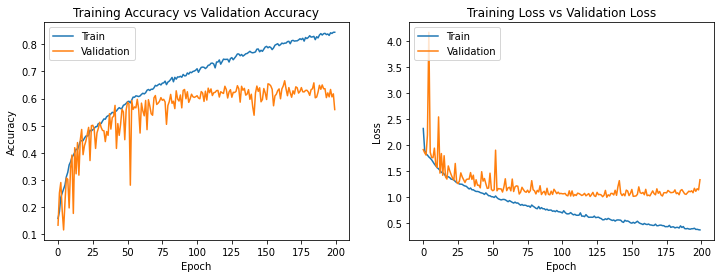

In [24]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [25]:
model.save('deeperdropout45_200_model.h5')
model.save_weights('deeperdropout45_200_weights.h5')

In [26]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

23/23 [==============================] - 3s 116ms/step - loss: 1.3393 - accuracy: 0.5594
final train accuracy = 75.44 , validation accuracy = 55.94


23/23 [==============================] - 4s 98ms/step
Confusion Matrix
[[26  1 59 36 16 45  8]
 [ 3  0  9  4  2  2  2]
 [23  5 55 44 23 44 10]
 [37  4 95 71 41 74 32]
 [42  1 59 38 28 63 15]
 [35  3 67 51 22 56 15]
 [21  4 40 39 24 29  9]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.14      0.14       191
     disgust       0.00      0.00      0.00        22
        fear       0.14      0.27      0.19       204
       happy       0.25      0.20      0.22       354
     neutral       0.18      0.11      0.14       246
         sad       0.18      0.22      0.20       249
    surprise       0.10      0.05      0.07       166

    accuracy                           0.17      1432
   macro avg       0.14      0.14      0.14      1432
weighted avg       0.17      0.17      0.17      1432



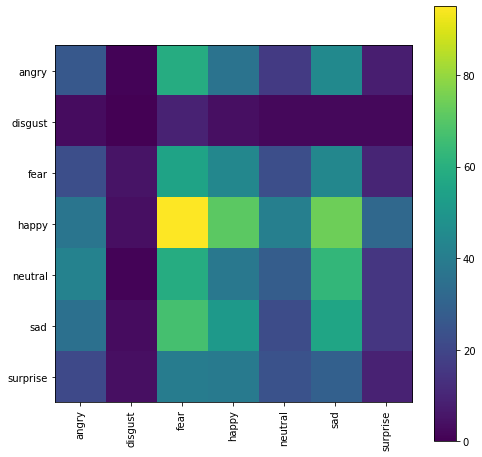

In [27]:
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = validation_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(validation_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

359/359 [==============================] - 31s 87ms/step
Confusion Matrix
[[ 446   45  684  711  346  706  258]
 [  41    7   71   81   41   79   29]
 [ 421   41  728  679  376  751  282]
 [ 808  103 1274 1231  651 1277  428]
 [ 511   55  851  878  475  915  287]
 [ 600   59  760  839  452  888  266]
 [ 352   38  502  560  304  585  196]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.14      0.14      3196
     disgust       0.02      0.02      0.02       349
        fear       0.15      0.22      0.18      3278
       happy       0.25      0.21      0.23      5772
     neutral       0.18      0.12      0.14      3972
         sad       0.17      0.23      0.20      3864
    surprise       0.11      0.08      0.09      2537

    accuracy                           0.17     22968
   macro avg       0.15      0.15      0.14     22968
weighted avg       0.18      0.17      0.17     22968



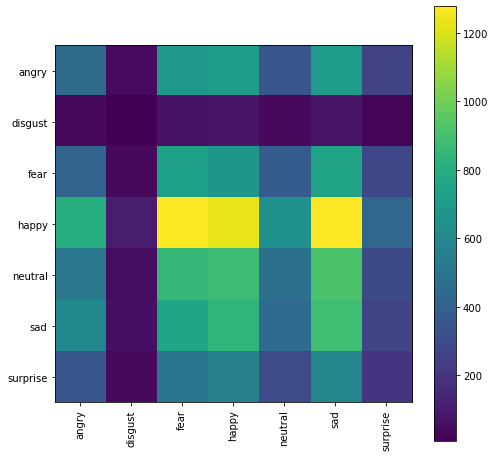

In [28]:
y_pred = model.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = train_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(train_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)